## Import necessary libraries

In [70]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [ ]:
df = pd.read_csv("IEA-EV-dataEV salesHistoricalCars.csv")

## Show dataset shape

In [3]:
print("Dataset shape:", df.shape)

Dataset shape: (3798, 8)


##  Display column names

In [4]:
print("\nColumn names:\n", df.columns.tolist())


Column names:
 ['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit', 'value']


## Show the first 5 rows

In [5]:
df.head()

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49.00000
1,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00039
2,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
3,Australia,Historical,EV stock,Cars,BEV,2011,Vehicles,49.00000
4,Australia,Historical,EV stock,Cars,BEV,2012,Vehicles,220.00000


## Show data types and missing values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      3798 non-null   object 
 1   category    3798 non-null   object 
 2   parameter   3798 non-null   object 
 3   mode        3798 non-null   object 
 4   powertrain  3798 non-null   object 
 5   year        3798 non-null   int64  
 6   unit        3798 non-null   object 
 7   value       3798 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 237.5+ KB


## Summary statistics for numeric and categorical data

In [7]:
df.describe()

,year,value
count,3798.000000,3.798000e+03
mean,2017.369932,1.009542e+05
std,3.809226,8.184402e+05
min,2010.000000,1.500000e-05
25%,2014.000000,2.300000e+00
50%,2018.000000,1.900000e+02
75%,2021.000000,6.800000e+03
max,2023.000000,2.800000e+07


## Count missing values per column

In [8]:
df.isnull().sum()

region        0
category      0
parameter     0
mode          0
powertrain    0
year          0
unit          0
value         0
dtype: int64

# Step 2: Feature Engineering

## Filter only EV sales

In [9]:
ev_sales_df = df[df['parameter'] == 'EV sales']

## Group total EV sales per region and year

In [10]:
region_year_sales = ev_sales_df.groupby(['region', 'year'])['value'].sum().reset_index()
region_year_sales.rename(columns={'value': 'total_sales'}, inplace=True)

## Calculate cumulative EV sales for each region

In [11]:
region_year_sales['cumulative_sales'] = region_year_sales.groupby('region')['total_sales'].cumsum()

##  Calculate Year-over-Year growth per region

In [12]:
region_year_sales['yoy_growth'] = region_year_sales.groupby('region')['total_sales'].pct_change() * 100

## Preview the result

In [13]:
region_year_sales.head(10)

,region,year,total_sales,cumulative_sales,yoy_growth
0,Australia,2011,49.0,49.0,NaN
1,Australia,2012,250.0,299.0,410.204082
2,Australia,2013,290.0,589.0,16.000000
3,Australia,2014,1320.0,1909.0,355.172414
4,Australia,2015,1760.0,3669.0,33.333333
5,Australia,2016,1370.0,5039.0,-22.159091
6,Australia,2017,2300.0,7339.0,67.883212
7,Australia,2018,3600.0,10939.0,56.521739
8,Australia,2019,9200.0,20139.0,155.555556
9,Australia,2020,6900.0,27039.0,-25.000000


# Step 3: Visualizations

## Line Plot: Global Sales Over Years

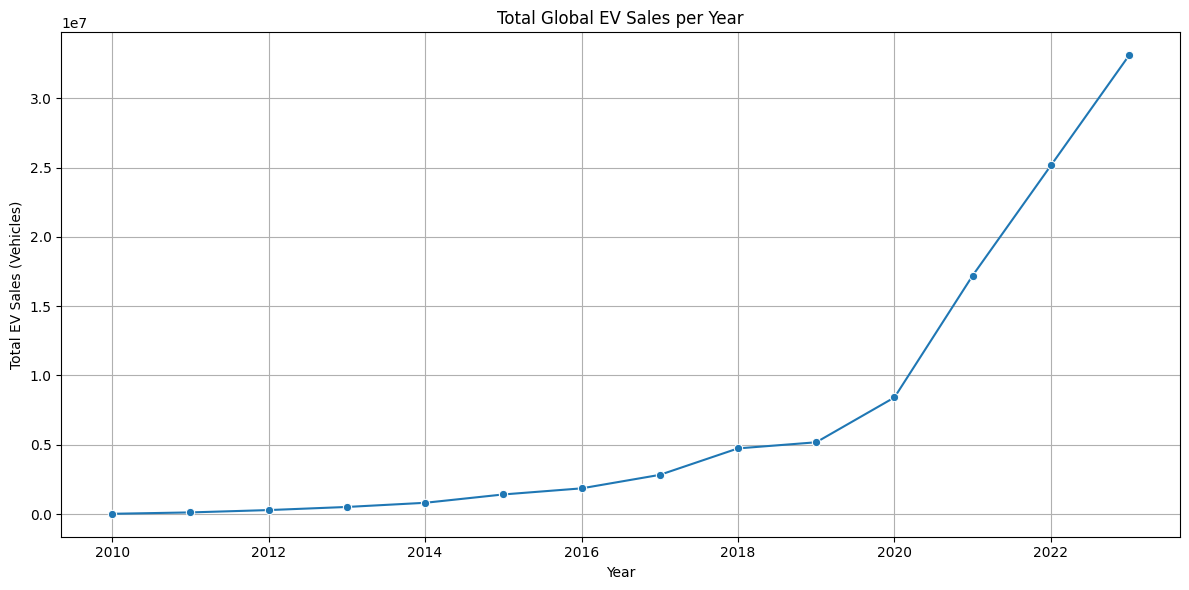

In [14]:
# Total global EV sales per year
global_sales = ev_sales_df.groupby('year')['value'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=global_sales, x='year', y='value', marker='o')
plt.title('Total Global EV Sales per Year')
plt.xlabel('Year')
plt.ylabel('Total EV Sales (Vehicles)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Bar Chart: Top Countries by Sales

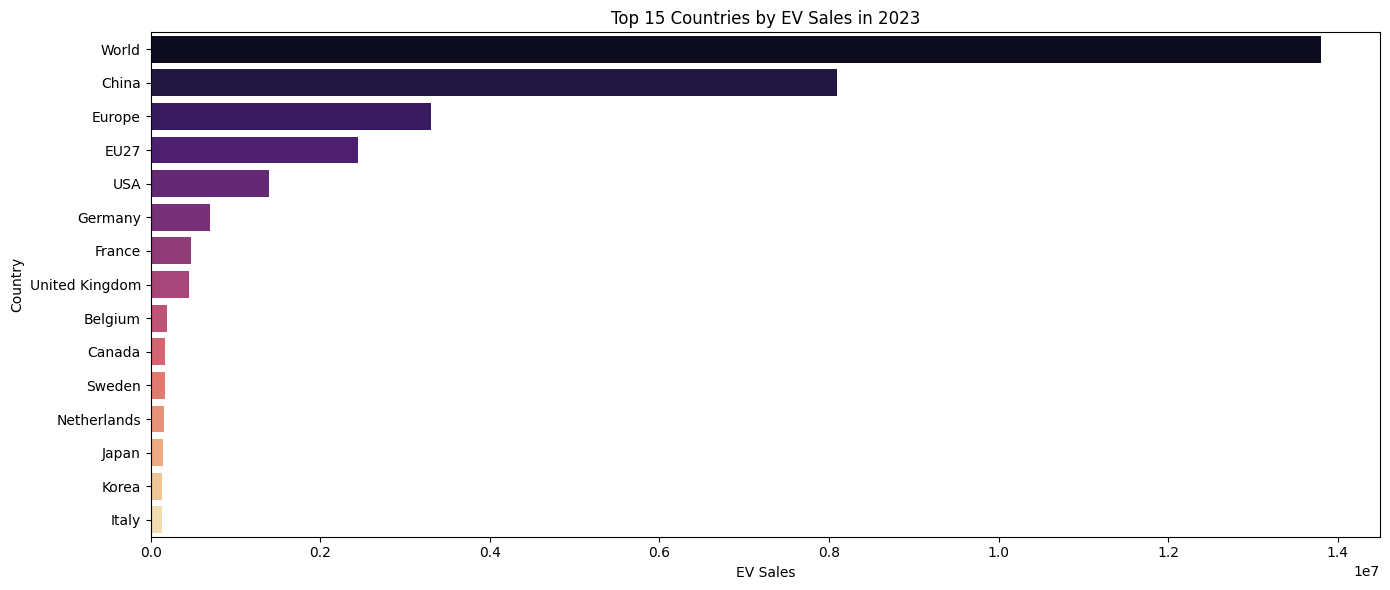

In [15]:
# Filter the most recent year
latest_year = ev_sales_df['year'].max()
top_countries = ev_sales_df[ev_sales_df['year'] == latest_year].groupby('region')['value'].sum().reset_index()
top_countries = top_countries.sort_values(by='value', ascending=False).head(15)

plt.figure(figsize=(14, 6))
sns.barplot(data=top_countries, x='value', y='region', palette='magma')
plt.title(f'Top 15 Countries by EV Sales in {latest_year}')
plt.xlabel('EV Sales')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

## Line Plot: Powertrain Sales Trend

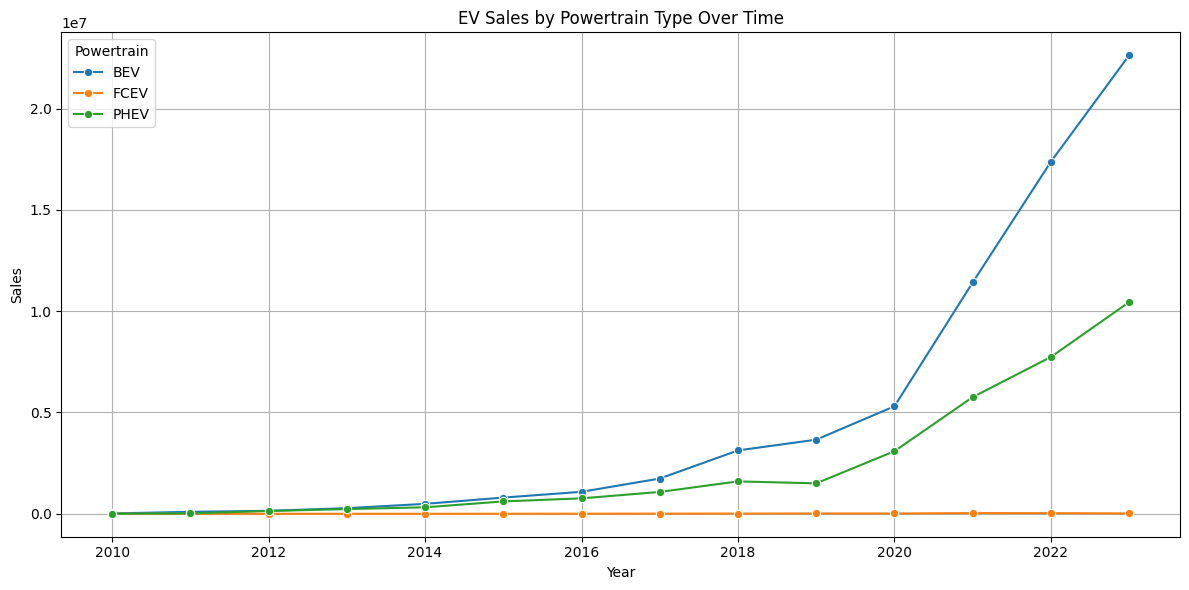

In [16]:
# Total sales by year and powertrain
powertrain_trend = ev_sales_df.groupby(['year', 'powertrain'])['value'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=powertrain_trend, x='year', y='value', hue='powertrain', marker='o')
plt.title('EV Sales by Powertrain Type Over Time')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(title='Powertrain')
plt.grid(True)
plt.tight_layout()
plt.show()

## Bar Chart: Total Sales by Powertrain

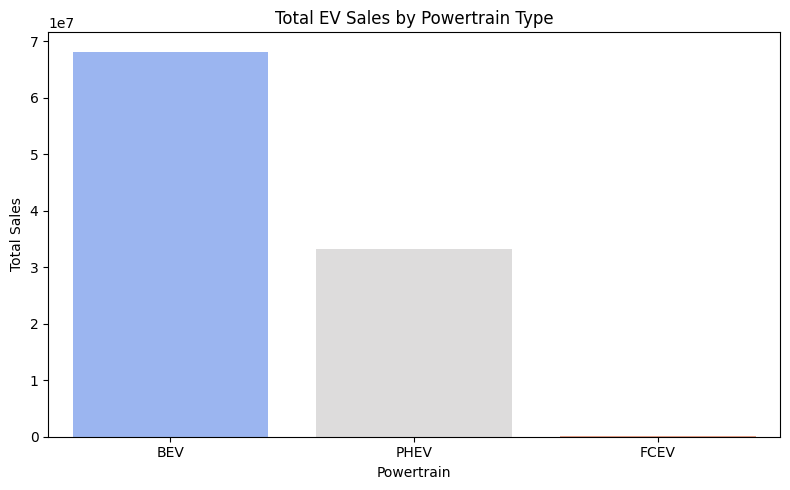

In [17]:
# Total sales by powertrain
total_powertrain = ev_sales_df.groupby('powertrain')['value'].sum().reset_index()
total_powertrain = total_powertrain.sort_values(by='value', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=total_powertrain, x='powertrain', y='value', palette='coolwarm')
plt.title('Total EV Sales by Powertrain Type')
plt.xlabel('Powertrain')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

## Heatmap: Sales by Region and Year

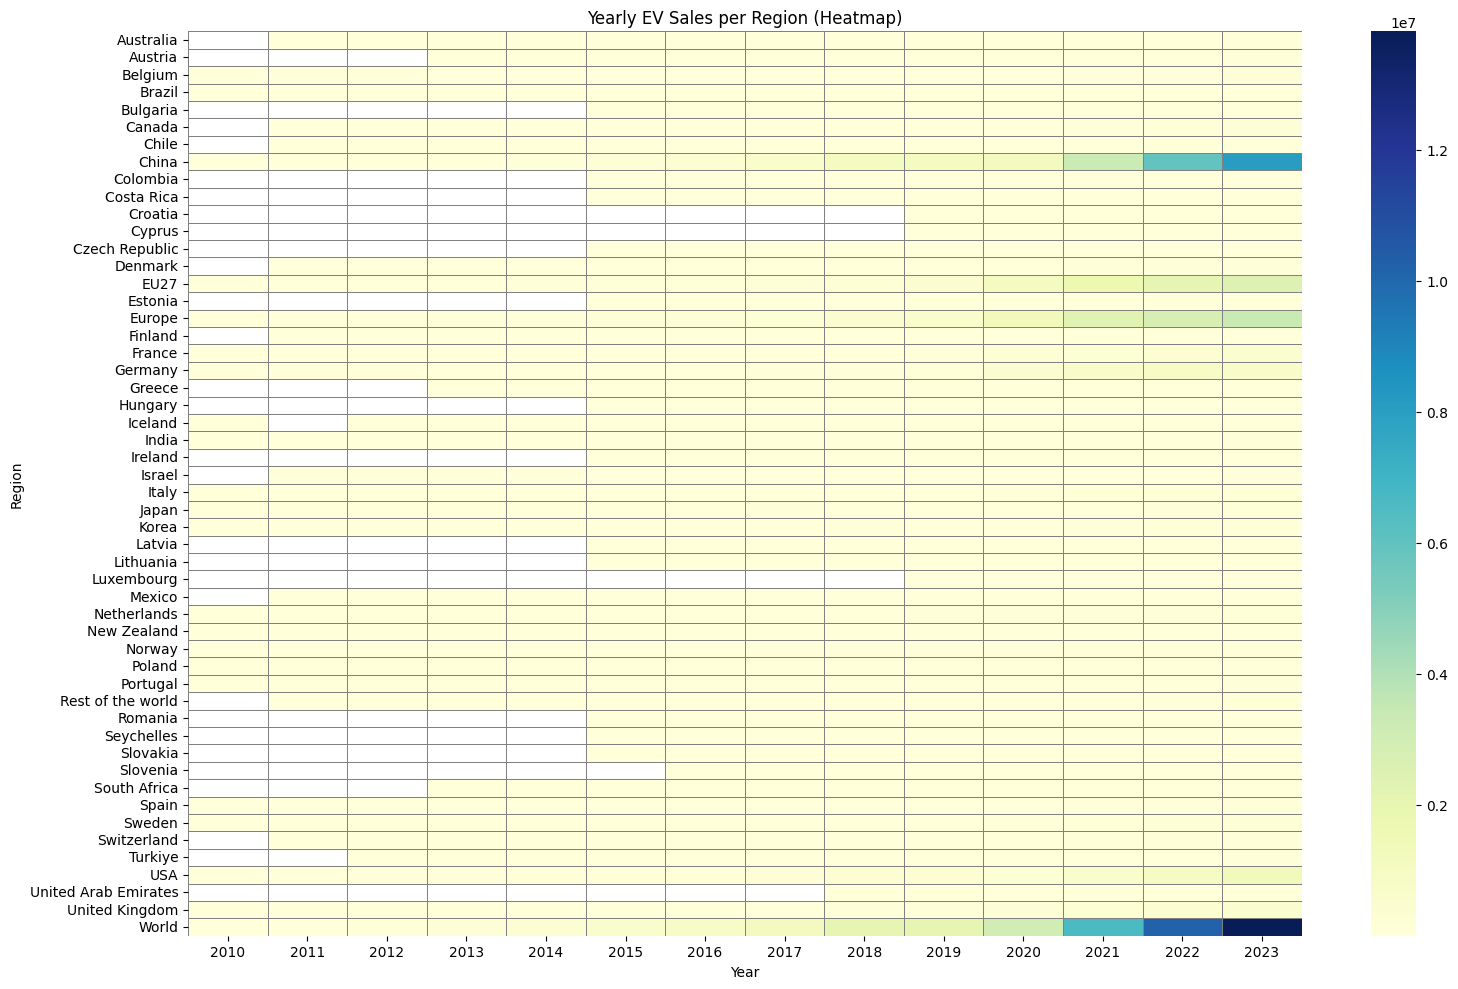

In [18]:
# Pivot table for heatmap
heatmap_data = region_year_sales.pivot(index='region', columns='year', values='total_sales')

plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title('Yearly EV Sales per Region (Heatmap)')
plt.xlabel('Year')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

# Step 4: Machine Learning Modeling

## Prepare the dataset

In [55]:
ml_df = df[df['parameter'] == 'EV sales'].groupby('year')['value'].sum().reset_index()
ml_df.rename(columns={'value': 'total_sales'}, inplace=True)

X = ml_df[['year']]
y = ml_df['total_sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


## Define models

In [56]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
}

## Train and evaluate

In [57]:
results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end = time.time()
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    duration = end - start

    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'Time (s)': duration
    })

## Show results

In [59]:
results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False).reset_index(drop=True)
results_df

,Model,MSE,RMSE,R²,Time (s)
0,Random Forest,8.538170e+10,2.922015e+05,0.982983,0.154616
1,Gradient Boosting,9.843297e+10,3.137403e+05,0.980382,0.090436
2,Decision Tree,9.851624e+10,3.138730e+05,0.980365,0.007364
3,AdaBoost,2.998873e+11,5.476197e+05,0.940231,0.129393
4,ElasticNet,2.886913e+13,5.373000e+06,-4.753800,0.010014
5,Ridge Regression,3.038370e+13,5.512141e+06,-5.055664,0.026628
6,Lasso Regression,3.074405e+13,5.544731e+06,-5.127483,0.015976
7,Linear Regression,3.074405e+13,5.544731e+06,-5.127484,0.041780


# Step 5 – Forecast Future Sales (2024–2030)

## Train the best model (Random Forest) on all data

In [60]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the Random Forest Regressor
rf = RandomForestRegressor()

# Create the RandomizedSearchCV object
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                              n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found:", rf_random.best_params_)

# Evaluate the best model
best_model = rf_random.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': True}
MSE: 101335178273.40813
RMSE: 318331.868139852
R²: 0.9798032554414766


In [61]:
best_model = RandomForestRegressor(n_estimators= 1000, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 20, bootstrap= True)
best_model.fit(X, y)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=1000)

## Create future year inputs

In [62]:
future_years = pd.DataFrame({'year': list(range(2024, 2031))})
future_preds = best_model.predict(future_years)

In [63]:
future_years

,year
0,2024
1,2025
2,2026
3,2027
4,2028
5,2029
6,2030


## Combine historical and future into a single DataFrame

In [64]:
historical_df = X.copy()
historical_df['total_sales'] = y
historical_df['type'] = 'Historical'

future_df = future_years.copy()
future_df['total_sales'] = future_preds
future_df['type'] = 'Forecast'

combined_df = pd.concat([historical_df, future_df], axis=0).reset_index(drop=True)

In [65]:
combined_df

,year,total_sales,type
0,2010,1.748100e+04,Historical
1,2011,1.167450e+05,Historical
2,2012,2.859100e+05,Historical
3,2013,5.103340e+05,Historical
4,2014,8.107122e+05,Historical
5,2015,1.412771e+06,Historical
6,2016,1.852523e+06,Historical
7,2017,2.825756e+06,Historical
8,2018,4.735114e+06,Historical
9,2019,5.177232e+06,Historical


## Plot both together

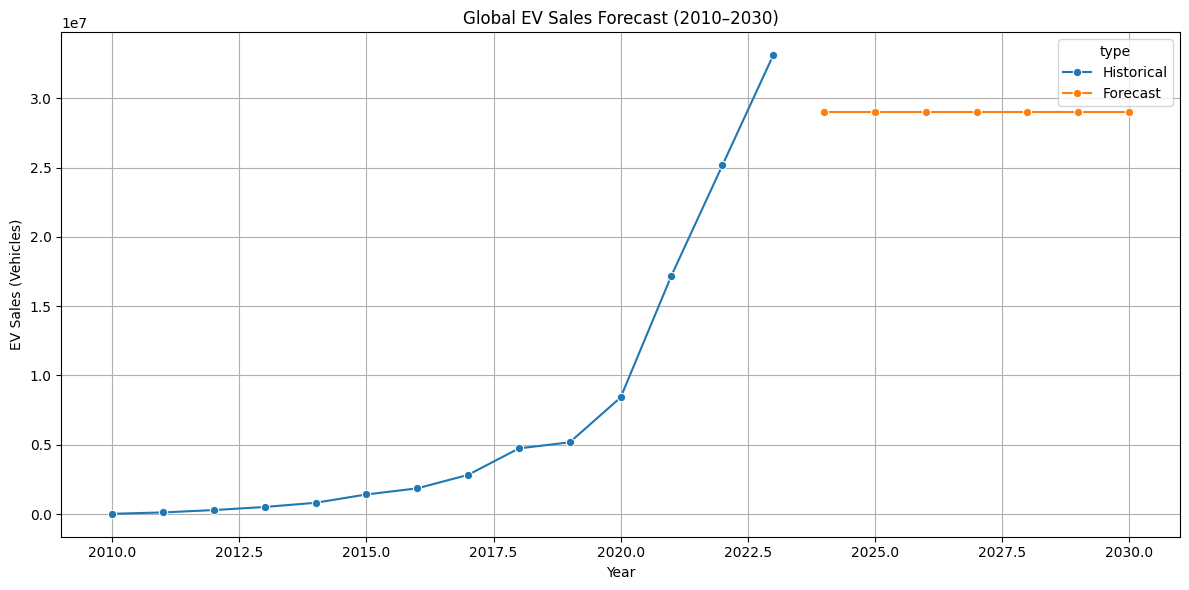

In [66]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='year', y='total_sales', hue='type', marker='o')
plt.title("Global EV Sales Forecast (2010–2030)")
plt.xlabel("Year")
plt.ylabel("EV Sales (Vehicles)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Result Interpretation & Visual Evaluation

## 7. ML – Actual vs Predicted (Best Model: Random Forest)

### Predict using Random Forest on full dataset

In [67]:
rf_model = RandomForestRegressor()
rf_model.fit(X, y)
y_rf_pred = rf_model.predict(X)

### Plot actual vs predicted

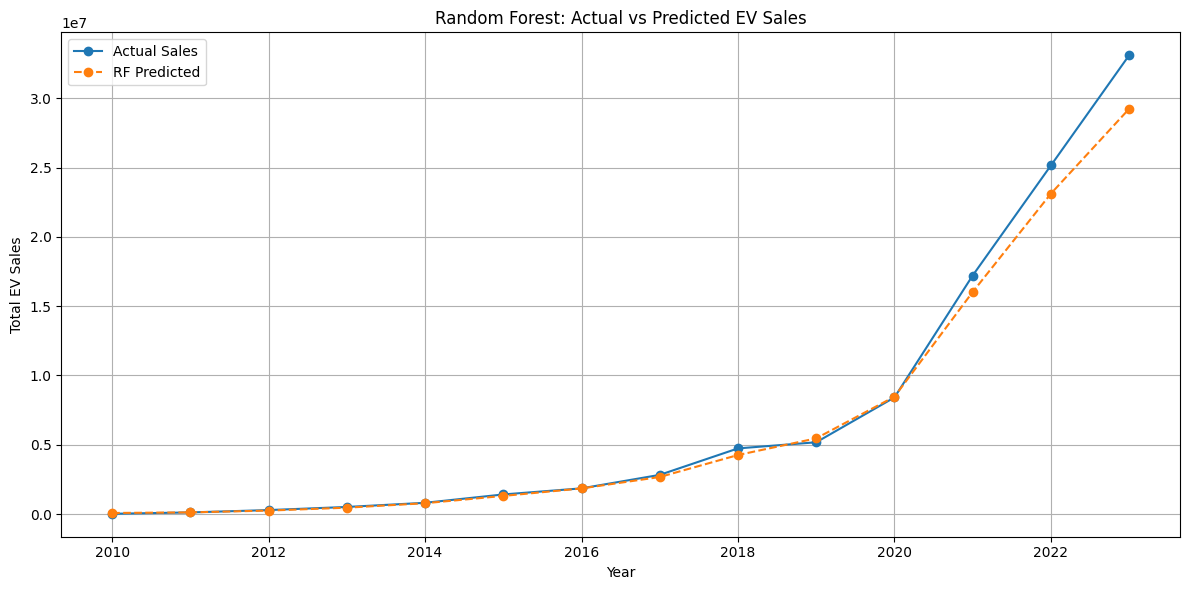

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(X['year'], y, label='Actual Sales', marker='o')
plt.plot(X['year'], y_rf_pred, label='RF Predicted', marker='o', linestyle='--')
plt.title("Random Forest: Actual vs Predicted EV Sales")
plt.xlabel("Year")
plt.ylabel("Total EV Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Deep Learning Models

## Prepare Data for Deep Learning

### Use yearly total EV sales data

In [71]:
dl_df = df[df['parameter'] == 'EV sales'].groupby('year')['value'].sum().reset_index()
dl_df.rename(columns={'value': 'total_sales'}, inplace=True)


### Normalize data

In [72]:
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(dl_df[['total_sales']])

### Create sequences (window size = 3 years)

In [73]:
X_dl, y_dl = [], []
window = 3
for i in range(window, len(scaled_sales)):
    X_dl.append(scaled_sales[i-window:i])
    y_dl.append(scaled_sales[i])

X_dl, y_dl = np.array(X_dl), np.array(y_dl)

### Split to train/test (80% train)

In [74]:
split = int(0.8 * len(X_dl))
X_train_dl, X_test_dl = X_dl[:split], X_dl[split:]
y_train_dl, y_test_dl = y_dl[:split], y_dl[split:]

## LSTM Model

### Reshape for LSTM input

In [75]:
X_train_lstm = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], 1))
X_test_lstm = X_test_dl.reshape((X_test_dl.shape[0], X_test_dl.shape[1], 1))


### Build LSTM model

In [76]:
model_lstm = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
history_lstm = model_lstm.fit(X_train_lstm, y_train_dl, epochs=200, verbose=0, validation_data=(X_test_lstm, y_test_dl))

## Compare Loss Plots

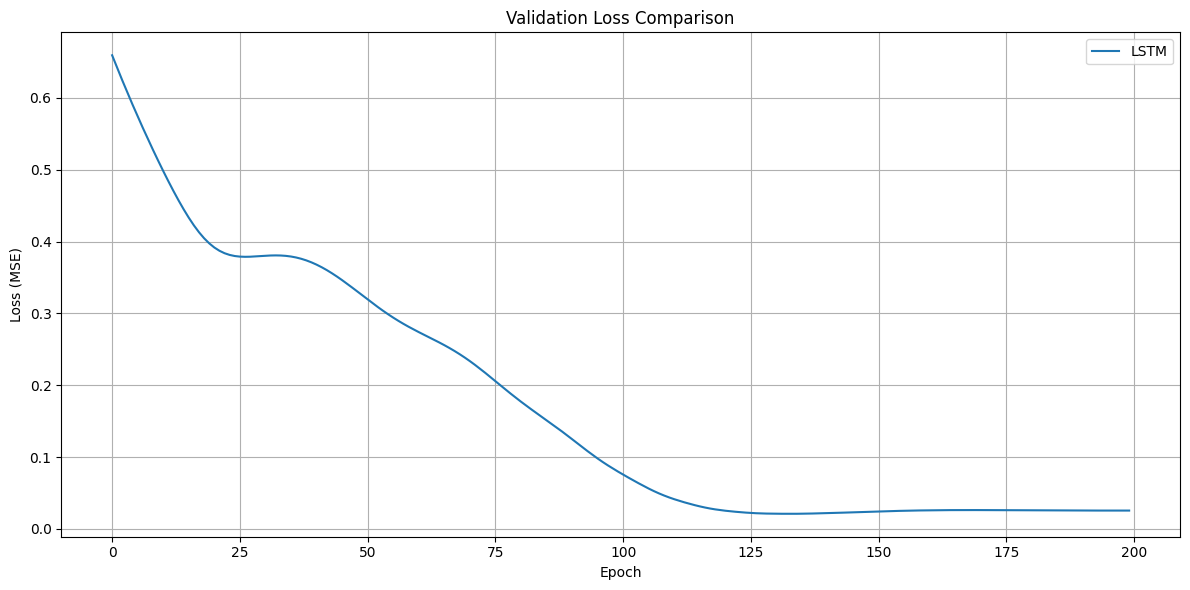

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['val_loss'], label='LSTM')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Forecast Future EV Sales (2024–2030) with LSTM

## Normalize data

In [78]:
dl_df = df[df['parameter'] == 'EV sales'].groupby('year')['value'].sum().reset_index()
dl_df.rename(columns={'value': 'total_sales'}, inplace=True)

scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(dl_df[['total_sales']])


## Predict future years using trained LSTM

In [79]:
last_sequence = scaled_sales[-3:]  # Last 3 years for prediction window
predictions_scaled = []

for _ in range(7):  # Predict 2024–2030
    input_seq = last_sequence[-3:].reshape(1, 3, 1)
    pred = model_lstm.predict(input_seq, verbose=0)
    predictions_scaled.append(pred[0][0])
    last_sequence = np.append(last_sequence, pred[0][0])

## Inverse transform to get real values

In [80]:
predicted_values = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()

## Create forecast years

In [81]:
forecast_years = list(range(2024, 2031))
actual_years = dl_df['year']
actual_values = dl_df['total_sales']


## Plot actual vs forecast

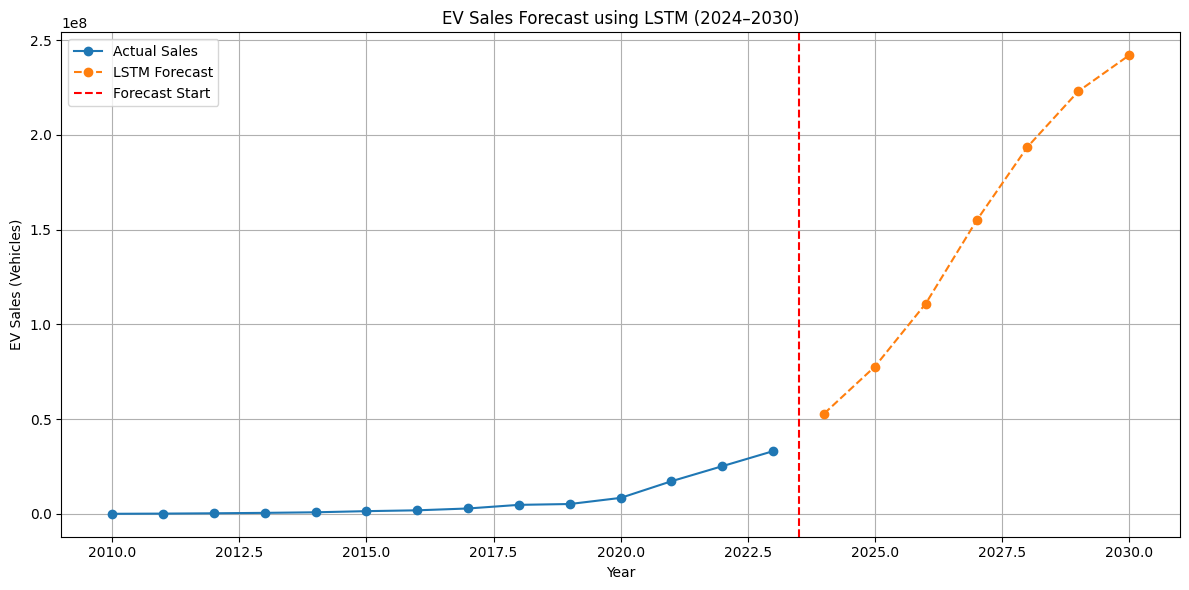

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(actual_years, actual_values, marker='o', label='Actual Sales')
plt.plot(forecast_years, predicted_values, marker='o', linestyle='--', label='LSTM Forecast')
plt.axvline(x=2023.5, color='red', linestyle='--', label='Forecast Start')
plt.title("EV Sales Forecast using LSTM (2024–2030)")
plt.xlabel("Year")
plt.ylabel("EV Sales (Vehicles)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save Model

In [84]:
model_lstm.save('lstm_model.keras')